In [ ]:
!pip install numba-cuda==0.4.0 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
  Attempting uninstall: numba-cuda
    Found existing installation: numba-cuda 0.2.0
    Uninstalling numba-cuda-0.2.0:
      Successfully uni

In [ ]:
# Required Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [ ]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

from numba import cuda, njit, prange
import numpy as np
#import pylab
from time import perf_counter
%matplotlib inline
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-7ff9c782-d6e4-d237-988a-4d7b930fd0d1
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [ ]:
#Loading the dataset
data = pd.read_csv("cumulative_csv.csv")

In [ ]:
data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


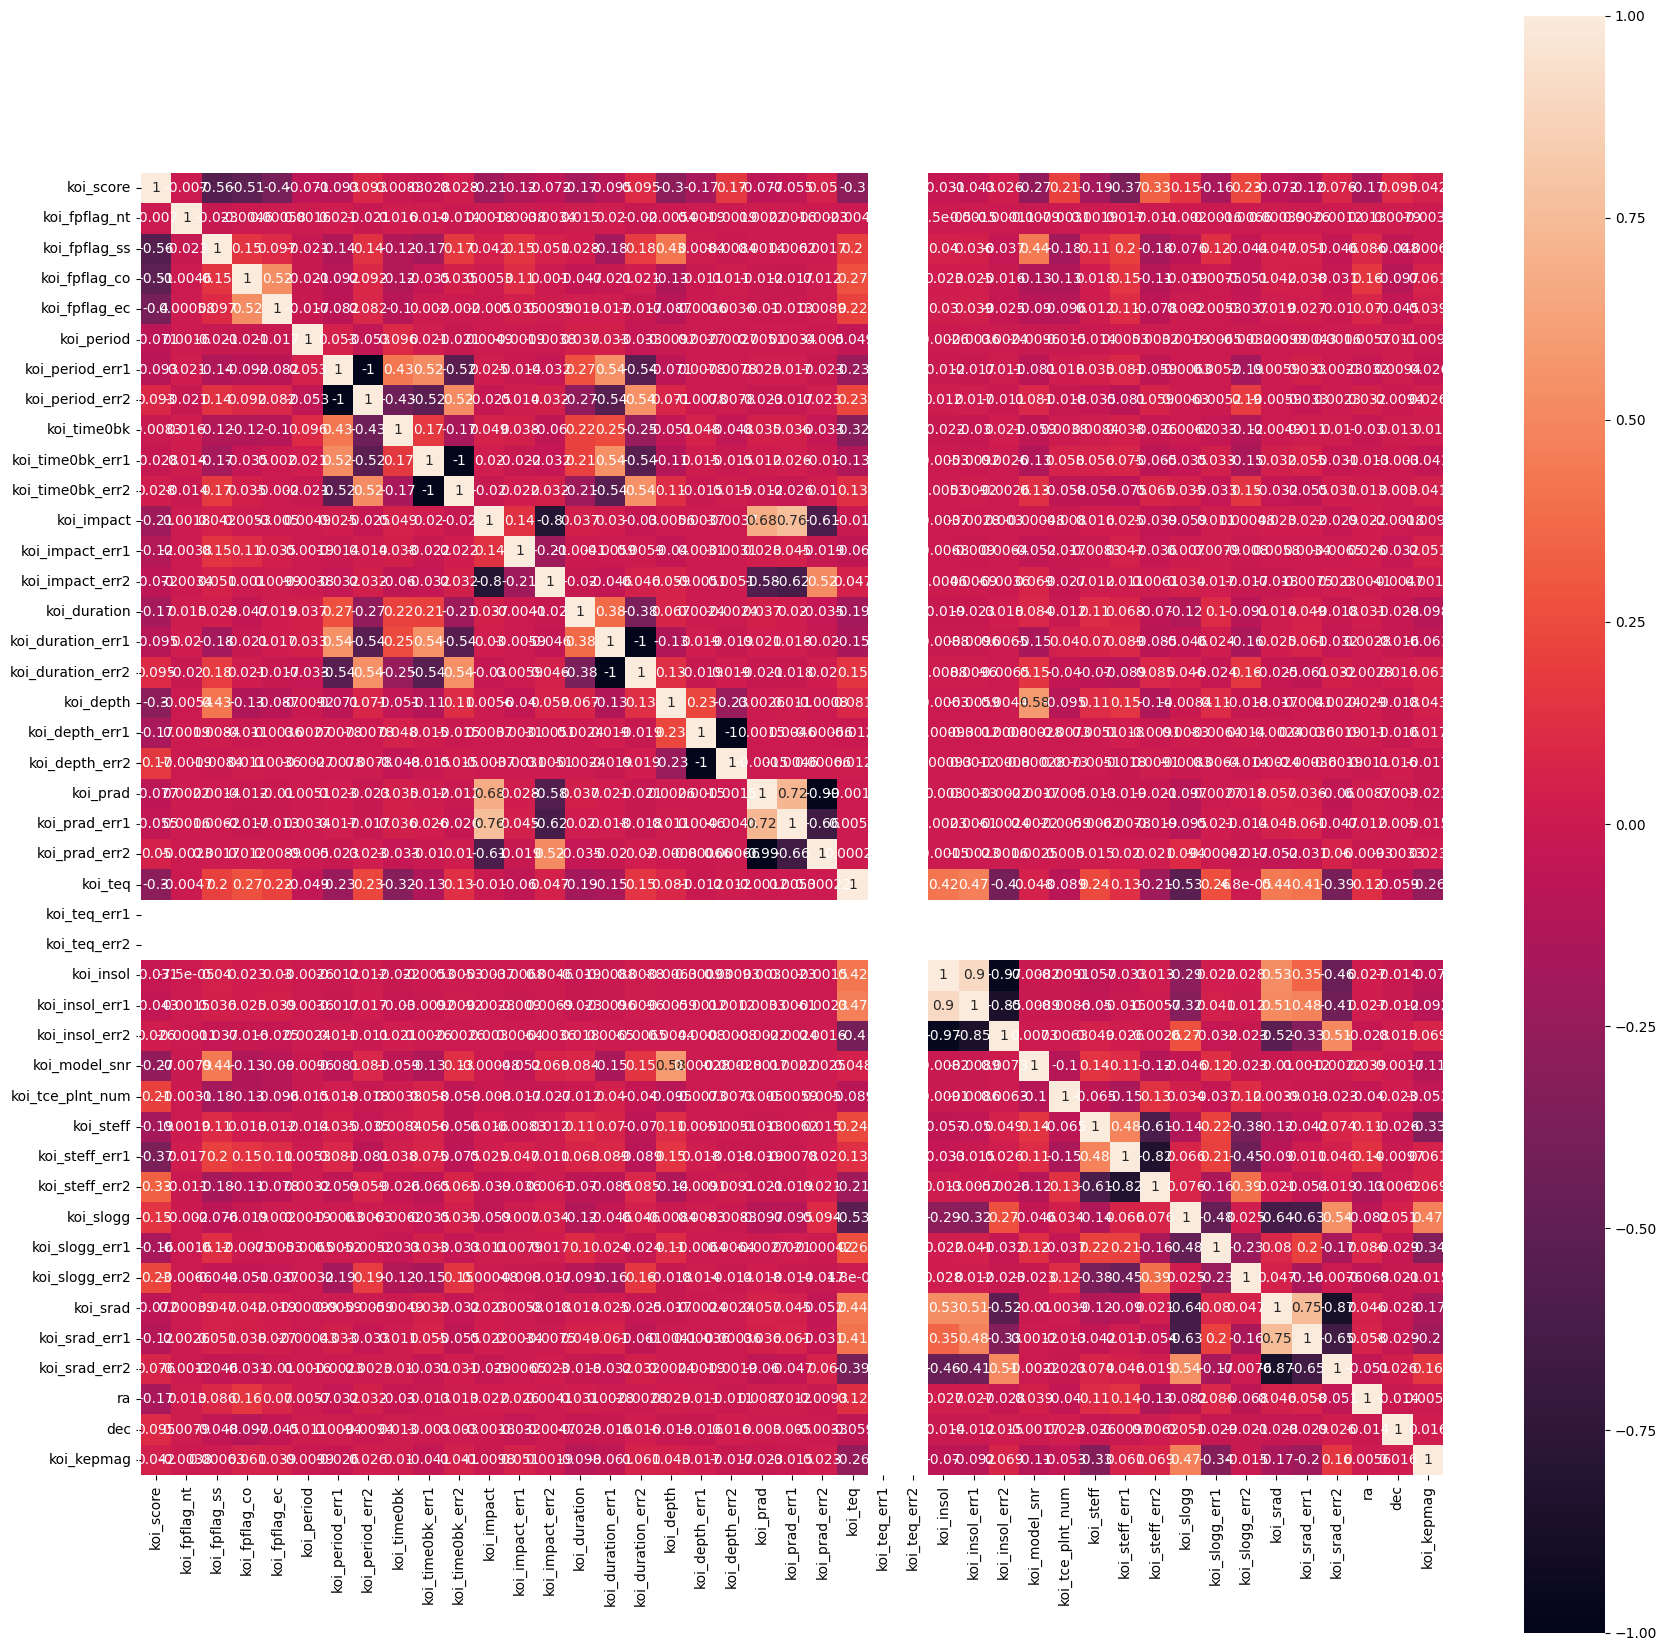

In [ ]:
df = data
df = df.drop(columns=['kepid' ,	'kepoi_name' ,	'kepler_name'	,'koi_disposition'	,'koi_pdisposition', 'koi_tce_delivname'])
plt.subplots(figsize=(21,21))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

In [ ]:
test_data=data[['koi_disposition','koi_fpflag_ss', 'koi_time0bk','koi_fpflag_co', 'koi_fpflag_ec', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_slogg', 'koi_srad', 'koi_kepmag']]
test_data = test_data[test_data['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])]
X = test_data.drop(columns=['koi_disposition'])  # Features
y = test_data['koi_disposition']  # Target variable (class label)
y = y.map({'CONFIRMED': 1, 'FALSE POSITIVE': 0})
print(X.shape)
print(y.shape)

(7582, 13)
(7582,)


In [ ]:
X.isnull().sum()

,0
koi_fpflag_ss,0
koi_time0bk,0
koi_fpflag_co,0
koi_fpflag_ec,0
koi_impact,259
koi_depth,259
koi_prad,259
koi_teq,259
koi_insol,219
koi_model_snr,259


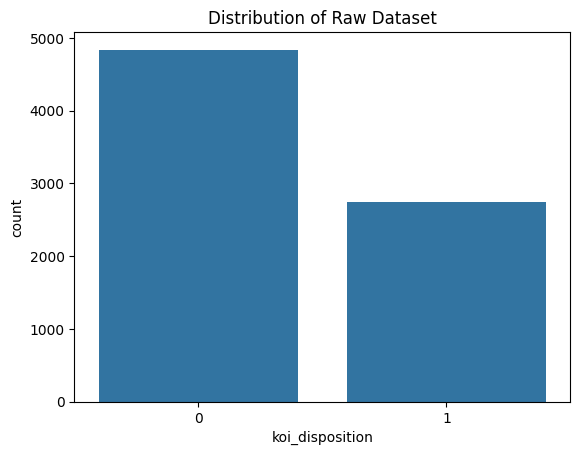

In [ ]:
sns.countplot(x=y)
plt.title("Distribution of Raw Dataset")
plt.show()

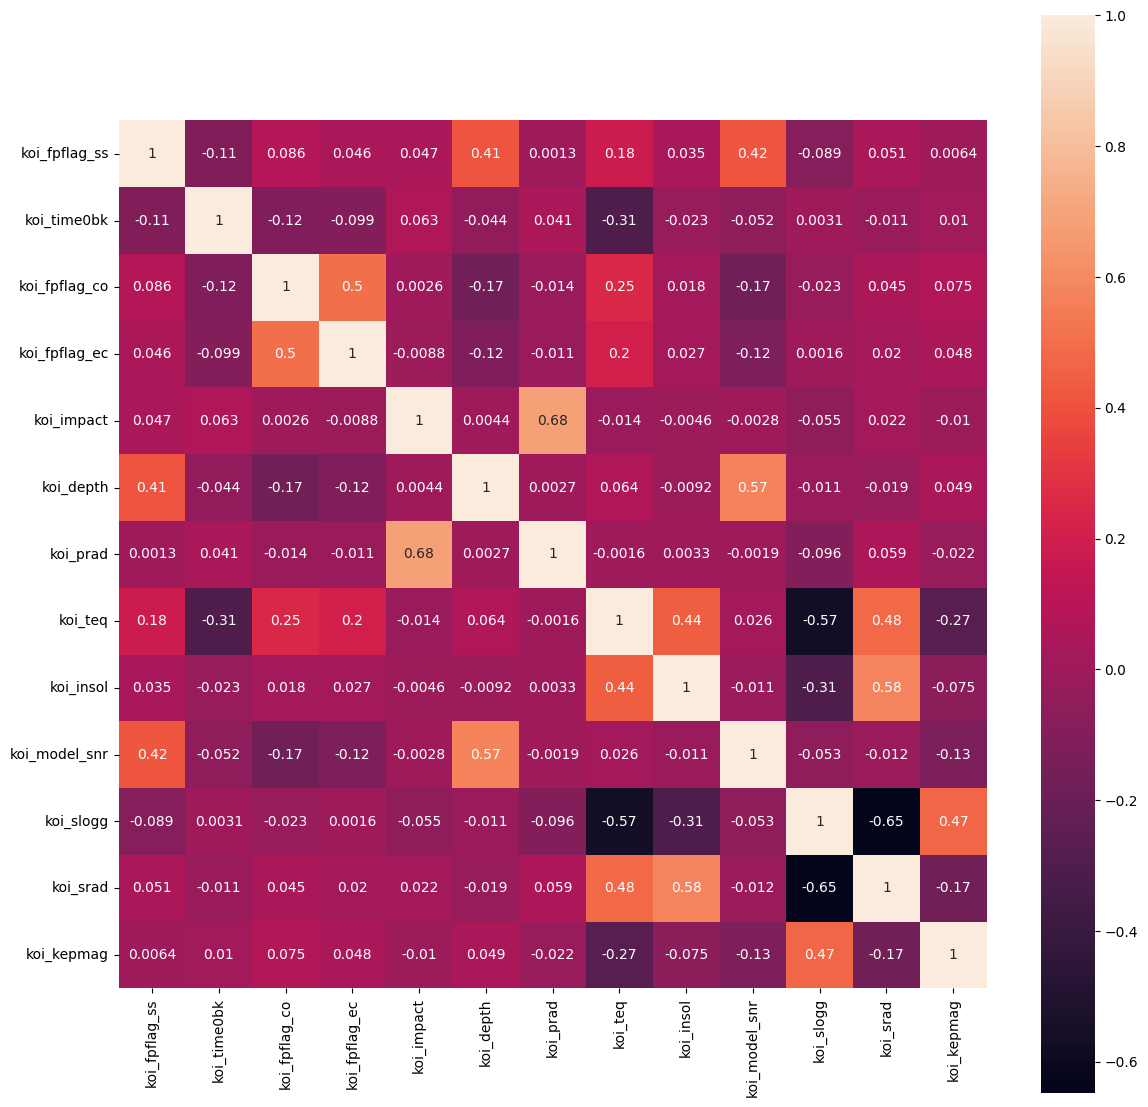

In [ ]:
# Heatmap
plt.subplots(figsize=(14,14))
sns.heatmap(X.corr(), square=True, annot=True)
plt.show()

In [ ]:
import copy
def z_score(a):
  features = ['koi_fpflag_ss', 'koi_time0bk','koi_fpflag_co', 'koi_fpflag_ec', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_slogg', 'koi_srad', 'koi_kepmag']
  for feature in features:
    mean = np.mean(a[feature])
    sd = np.std(a[feature])
    a[feature] = (a[feature] - mean)/sd

  return a

In [ ]:
# Outlier Removal
A = copy.deepcopy(X)
z_scores = np.abs(z_score(A))

threshold = 3
outlier_mask = (z_scores < threshold).all(axis=1)  # Keep only non-outliers

X_clean = X[outlier_mask]
y_clean = y[outlier_mask]

print(X_clean.shape)
print(y_clean.shape)

(6424, 13)
(6424,)


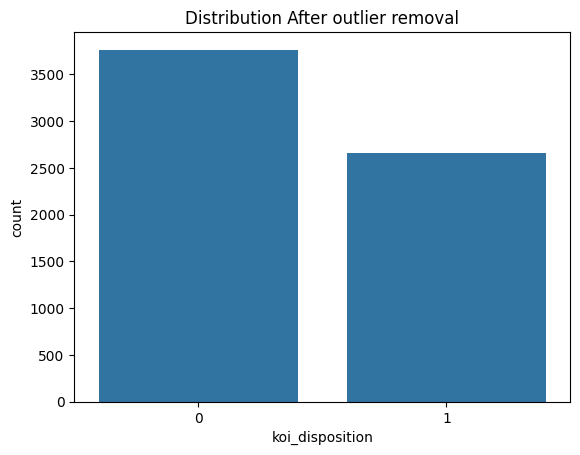

In [ ]:
sns.countplot(x=y_clean)
plt.title("Distribution After outlier removal")
plt.show()

In [ ]:
# Mean Substitution
X_clean.fillna(X_clean.mean(), inplace = True)
X_clean.isnull().sum()

<ipython-input-11-01aa3c2a1720>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean.fillna(X_clean.mean(), inplace = True)


,0
koi_fpflag_ss,0
koi_time0bk,0
koi_fpflag_co,0
koi_fpflag_ec,0
koi_impact,0
koi_depth,0
koi_prad,0
koi_teq,0
koi_insol,0
koi_model_snr,0


In [ ]:
def confusion_matrix(y_test, y_pred):
  y_pred = list(y_pred)
  y_test = list(y_test)
  tp=tn=fp=fn=0
  for i in range(0,len(y_test)):
    if y_test[i]==y_pred[i] and y_test[i]==1:
      tp = tp+1
    elif y_test[i]==y_pred[i] and y_test[i]==0:
      tn = tn+1
    elif y_test[i]!=y_pred[i] and y_test[i]==1:
      fn = fn+1
    elif y_test[i]!=y_pred[i] and y_test[i]==0:
      fp = fp+1

  matrix = np.zeros((2,2))
  matrix[0][0] = tp
  matrix[0][1] = fn
  matrix[1][0] = fp
  matrix[1][1] = tn
  print(matrix)

  plt.subplots(figsize=(6,6))
  sns.heatmap(matrix, square=True, annot=True, fmt='g')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
def classification_report(y_test, y_pred):
  y_pred = list(y_pred)
  y_test = list(y_test)
  tp=tn=fp=fn=0
  for i in range(0,len(y_test)):
    if y_test[i]==y_pred[i] and y_test[i]==1:
      tp = tp+1
    elif y_test[i]==y_pred[i] and y_test[i]==0:
      tn = tn+1
    elif y_test[i]!=y_pred[i] and y_test[i]==1:
      fn = fn+1
    elif y_test[i]!=y_pred[i] and y_test[i]==0:
      fp = fp+1

  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1score = 2*recall*precision/(recall+precision)
  print("Recall : ",recall)
  print("F1 Score : ",f1score)
  print("Precision : ",precision)

In [ ]:
#final KNN
from numba import cuda, float32
@cuda.jit
def distance_cuda(X_test, X_train, d_dist, test_idx):
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if idx < X_train.shape[0]:
        dist = 0.0
        for j in range(X_train.shape[1]):
            diff = X_test[test_idx, j] - X_train[idx, j]
            dist += abs(diff)
        d_dist[idx] = dist

def cuda_knn(k, p, X_test, X_train, y_train):
    y_pred = np.zeros(X_test.shape[0])
    h_dist = np.zeros(X_train.shape[0], dtype=np.float32)

    threadsperblock = 32
    blockspergrid = (X_train.shape[0] + (threadsperblock - 1)) // threadsperblock

    X_test_np = np.array(X_test, dtype=np.float32) # converted as kernel can handle only numpy arrays
    X_train_np = np.array(X_train, dtype=np.float32)

    d_X_test = cuda.to_device(X_test_np)
    d_X_train = cuda.to_device(X_train_np)

    for i in range(X_test_np.shape[0]):
        d_dist = cuda.to_device(h_dist)
        distance_cuda[blockspergrid, threadsperblock](d_X_test, d_X_train, d_dist, i)
        cuda.synchronize()
        d_dist.copy_to_host(h_dist)

        # Now perform KNN selection on CPU (you can optimize this too)
        nearest_indices = np.argsort(h_dist)[:k]
        nearest_labels = y_train[nearest_indices]
        y_pred[i] = np.bincount(nearest_labels).argmax()

    return y_pred

In [ ]:
#Cuda knn for smote
class CudaKnn:
  def __init__(self,neighbors=5):
    self.neighbors = neighbors #basically the value of k
    self.X_train = None


  def fit(self,X_train):
    self.X_train = np.array(X_train)
    return self

  def k_cuda_neighbors(self,X_test):
    h_dist = np.zeros(self.X_train.shape[0], dtype=np.float32)
    nearest_indices = []

    threadsperblock = 32
    blockspergrid = (self.X_train.shape[0] + (threadsperblock - 1)) // threadsperblock

    X_test_np = np.array(X_test, dtype=np.float32)
    d_X_test = cuda.to_device(X_test)
    d_X_train = cuda.to_device(self.X_train)

    for i in range(X_test_np.shape[0]):
        d_dist = cuda.to_device(h_dist)
        distance_cuda[blockspergrid, threadsperblock](d_X_test, d_X_train, d_dist, i)
        cuda.synchronize()
        d_dist.copy_to_host(h_dist)
        nearest_indices.append(np.argsort(h_dist)[:self.neighbors])

    return np.array(nearest_indices)

In [ ]:
#SMOTE For Data balancing
def Smote(X, y, minority_class, k=5):
    minority_samples = X[y == minority_class]
    number_minority = minority_samples.shape[0]

    majority_samples = X[y != minority_class]
    number_majority = majority_samples.shape[0]

    samples_to_generate = number_majority - number_minority

    knn = CudaKnn(k+1).fit(minority_samples.values)

    synthetic_samples = []
    samples_per_minority = -(-samples_to_generate // number_minority)

    for i in range(number_minority):
        neighbors = knn.k_cuda_neighbors([minority_samples.iloc[i].values])[0]
        neighbors = neighbors[1:]
        samples_to_create = min(samples_per_minority,
                               samples_to_generate - len(synthetic_samples))

        for _ in range(samples_to_create):
            neighbor_idx = np.random.choice(neighbors)
            diff = minority_samples.iloc[neighbor_idx].values - minority_samples.iloc[i].values
            new_sample = minority_samples.iloc[i].values + np.random.random() * diff

            synthetic_samples.append(new_sample)
            if len(synthetic_samples) >= samples_to_generate:
                break
    synthetic_samples = pd.DataFrame(synthetic_samples, columns=X.columns)
    X_resampled = pd.concat([X, synthetic_samples], ignore_index=True)
    y_resampled = pd.concat([y, pd.Series([minority_class] * len(synthetic_samples))], ignore_index=True)
    return X_resampled, y_resampled

In [ ]:
#final test_train_split function
def test_train_split(X,y):
  X_0 = X[y==0]
  X_1 = X[y==1]
  y_0 = y[y==0]
  y_1 = y[y==1]

  rowsy0 = (int)(0.8*y_0.shape[0])
  rowsy1 = (int)(0.8*y_1.shape[0])

  X_train = pd.concat([X_0[:rowsy0], X_1[:rowsy1]], axis=0)
  y_train = pd.concat([y_0[:rowsy0], y_1[:rowsy1]], axis=0)

  X_test = pd.concat([X_0[rowsy0:], X_1[rowsy1:]], axis=0)
  y_test = pd.concat([y_0[rowsy0:], y_1[rowsy1:]], axis=0)

  indexes = X_train.sample(frac = 1, random_state = 42).index

  X_train = X_train.loc[indexes].reset_index(drop = True)
  y_train = y_train.loc[indexes].reset_index(drop = True)
  indexes_test = X_test.sample(frac = 1, random_state = 42).index
  X_test = X_test.loc[indexes_test].reset_index(drop = True)
  y_test = y_test.loc[indexes_test].reset_index(drop = True)

  return X_train, X_test, y_train, y_test

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 84 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(7530, 13)
(7530,)


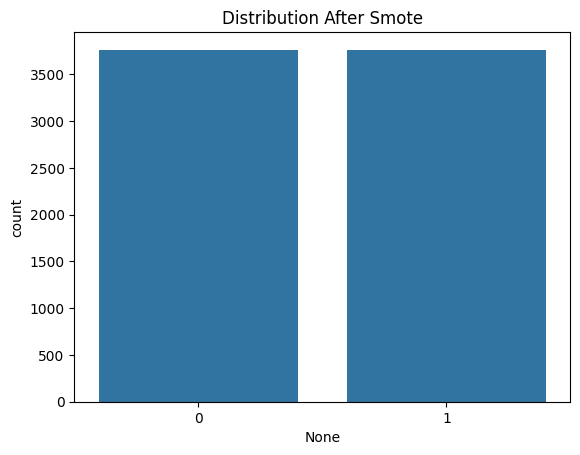

In [ ]:
# Applying Smote to Balance the Dataset
X_balanced, y_balanced = Smote(X_clean,y_clean,1,5)
print(X_balanced.shape)
print(y_balanced.shape)

sns.countplot(x=y_balanced)
plt.title("Distribution After Smote")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = test_train_split(X_clean, y_clean)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5139, 13)
(5139,)
(1285, 13)
(1285,)


In [ ]:
# Scaling down the data using Mean Normalization
features = ['koi_time0bk', 'koi_impact', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_slogg', 'koi_srad', 'koi_kepmag']
for feature in features:
  mean = np.mean(X_train[feature])
  X_train[feature]/= mean
  X_test[feature]/= mean

In [ ]:
def accuracy(y_test, y_pred):
  total= len(y_test)
  count=0
  for i in range(0,total):
    if y_test.iloc[i]==y_pred[i]:
      count+=1
  return count/total

Text(0, 0.5, 'Error Rate')

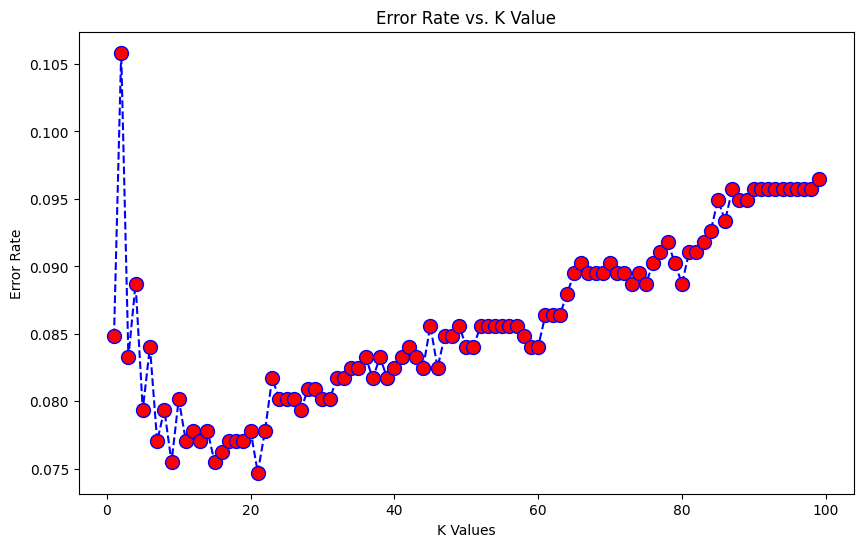

In [ ]:
# Elbow Plot
err = []
acc = []
for i in range(1,100):
  y_pred = cuda_knn(i, 1, X_test, X_train, y_train)
  acc.append(accuracy(y_test,y_pred))
  err.append(np.mean(y_pred != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),err,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Values')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Accuracy')

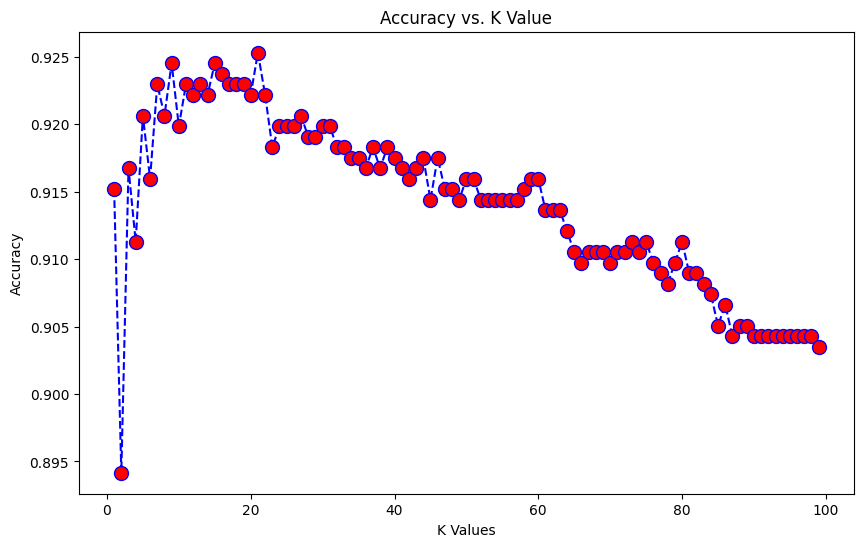

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),acc,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K Values')
plt.ylabel('Accuracy')

0.9252918287937744

Confusion Matrix
[[483.  49.]
 [ 47. 706.]]


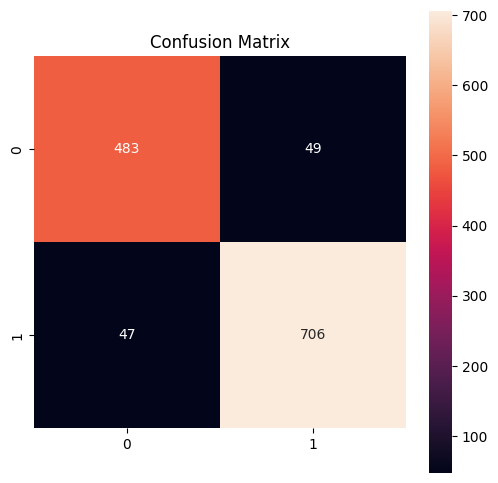


Classification Report
Recall :  0.9078947368421053
F1 Score :  0.9096045197740112
Precision :  0.9113207547169812


In [ ]:
#Final Cell for accuracy calculation
y_pred = cuda_knn(21, 1, X_test, X_train, y_train)
acc = accuracy(y_test, y_pred)
print(acc)
print("\nConfusion Matrix")
confusion_matrix(y_test,y_pred)
print("\nClassification Report")
classification_report(y_test,y_pred)

In [ ]:
#include evaluation metrics, F1 score, recall, Confusion Martix, ROC Curve